In [2]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.autograd.profiler as profiler
from scipy.constants import *
import time

from simulator import *
from utils import *
from physics import *

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(2304)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
Lx, Ly = 1.0, 1.0
Nx, Ny = 64, 64
dt = 1e-5
simulation_time = 1e-3
normalization = 1.0

backend = "cpu"

sim = Space(
    Lx=Lx,
    Ly=Ly,
    Nx=Nx,
    Ny=Ny,
    simulation_time=simulation_time,
    dt=dt,
    normalization=normalization,
    boundaries_type="periodic",
    save_frequency=1,
    backend= backend,
)

sim.poisson_method = "gauss_seidel"


# Creiamo ioni fissi come background neutro
# (In pratica, potremmo rendere la loro velocità nulla e la loro massa molto grande
#  oppure semplicemente ignorarli e aggiungere un background di carica su griglia,
#  a seconda di come vogliamo approssimare.)
num_ioni = 5000
sim.create_new_specie(
    name="ioni",
    num_particles=num_ioni,
    temperature=0.0,
    distribution="zero",
    mass=1836.0,
    charge=1.0,
    disposition="random"
)

# Creiamo due fasci di elettroni
num_elettroni = 5000

# Fascio 1 con +vx
sim.create_new_specie(
    name="electrons_beam1",
    num_particles=num_elettroni,
    temperature=0.0,
    distribution="zero",
    mass=1.0,
    charge=-1.0,
    disposition="random"
)
# Assegniamo loro una velocità vx>0
is_beam1 = (sim.particles_specie == sim.name_register.tolist().index("electrons_beam1"))
sim.particles_velocity[is_beam1, 0] = 0.2  # velocità in +x

# Fascio 2 con -vx
sim.create_new_specie(
    name="electrons_beam2",
    num_particles=num_elettroni,
    temperature=0.0,
    distribution="zero",
    mass=1.0,
    charge=-1.0,
    disposition="random"
)
# Assegniamo loro una velocità vx<0
is_beam2 = (sim.particles_specie == sim.name_register.tolist().index("electrons_beam2"))
sim.particles_velocity[is_beam2, 0] = -0.2  # velocità in -x

sim.simulate()


100%|██████████| 100/100 [01:57<00:00,  1.18s/ step]

Energia potenziale (E field) nel tempo: [4.754620708972134e+16, 4.291881791494554e+16, 4.698472172014797e+16, 4.697122263793664e+16, 4.567304300291686e+16, 4.539366397024666e+16, 4.578067058838733e+16, 4.683956471044506e+16, 4.681701613214106e+16, 4.7240882159616e+16, 4.752169571136307e+16, 4.485586105034342e+16, 4.490138340871373e+16, 4.753133791294259e+16, 4.584654679677338e+16, 4.840168726567322e+16, 5.113712187172454e+16, 4.526780854357197e+16, 4.770724259351757e+16, 4.867436185439437e+16, 4.417601067705958e+16, 4.547684889683558e+16, 4.589217223435878e+16, 4.605880837550899e+16, 4.830136971454054e+16, 4.92624115966935e+16, 4.67803499963351e+16, 4.499896936064614e+16, 4.538795166374298e+16, 4.757767202013184e+16, 4.461519255791206e+16, 4.445529092548198e+16, 4.84418580947927e+16, 4.888583315914752e+16, 4.656596240878797e+16, 4.760711831591322e+16, 4.73342934033367e+16, 5.144303950731674e+16, 4.577805065833677e+16, 4.860905687665869e+16, 4.970731437398426e+16, 4.580438739779584e+16,

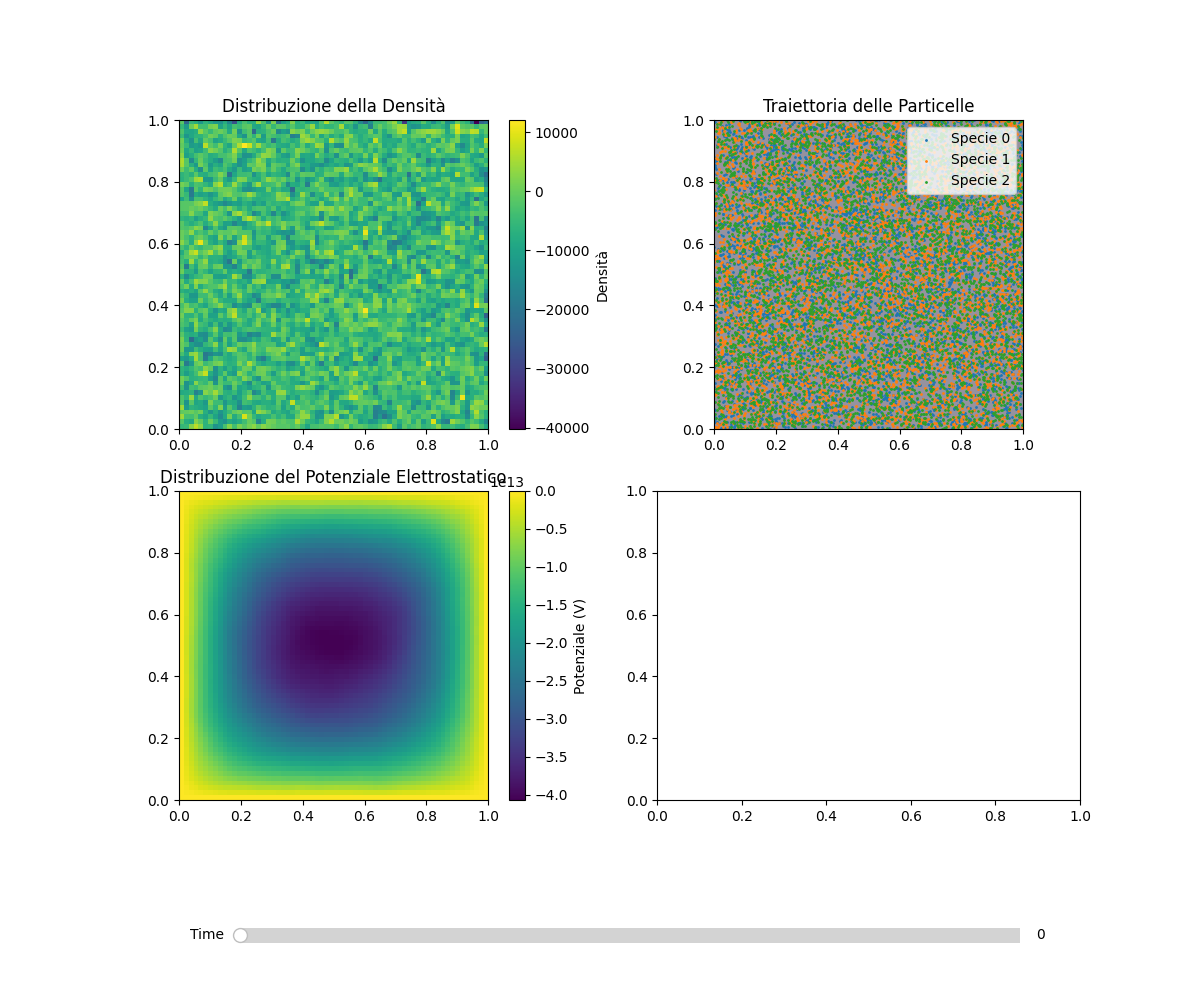

In [4]:
%matplotlib widget
particles_position_chronology = sim.particles_position_chronology
particles_velocity_chronology = sim.particles_velocity_chronology
fields_chronology = sim.fields_chronology
grid_chronology = sim.grid_chronology
particles_specie_chronology = sim.particles_specie_chronology
kinetic_energy_chronology = sim.kinetic_energy_chronology
potential_energy_chronology = sim.potential_energy_chronology
mechanic_energy_chronology = sim.mechanic_energy_chronology
particles_position_chronology = torch.stack(particles_position_chronology).cpu().numpy()
particles_velocity_chronology = torch.stack(particles_velocity_chronology).cpu().numpy()
fields_chronology = torch.stack(fields_chronology).cpu().numpy()
grid_chronology = torch.stack(grid_chronology).cpu().numpy()
particles_specie_chronology = torch.stack(particles_specie_chronology).cpu().numpy()
kinetic_energy_chronology = np.array(kinetic_energy_chronology)
potential_energy_chronology = np.array(potential_energy_chronology)
mechanic_energy_chronology = np.array(mechanic_energy_chronology)



dynamic_slider(fields_chronology, grid_chronology, particles_position_chronology, particles_specie_chronology, Lx, Ly, sim.solid_mask.cpu().numpy(), sim.fixed_potential_value.cpu().numpy())

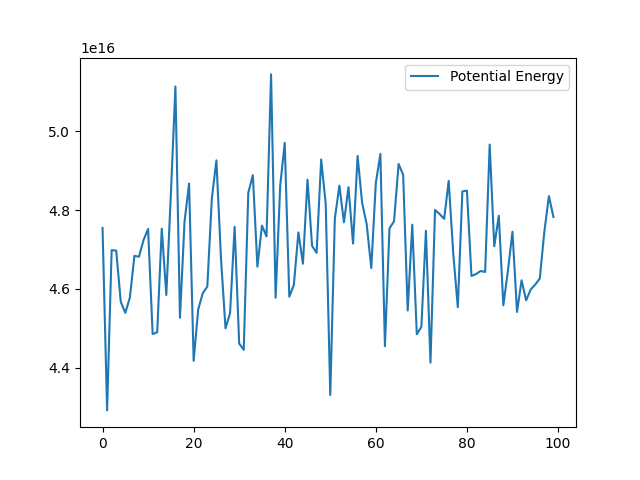

In [7]:
plt.close()
plt.figure()
plt.plot(sim.kinetic_energy_chronology, label="Kinetic Energy")
plt.plot(sim.potential_energy_chronology, label="Potential Energy")
plt.plot(sim.mechanic_energy_chronology, label="Mechanical Energy")
plt.legend()
plt.show()